# Pypam

## 0. Setup

In [1]:
import sys
sys.path = ['.'] + sys.path
!pip install pvlib
!pip uninstall lifewatch-pypam -y
!pip install git+https://github.com/lifewatch/pypam.git
!pip install minio

Found existing installation: lifewatch-pypam 0.2.1
Uninstalling lifewatch-pypam-0.2.1:
  Successfully uninstalled lifewatch-pypam-0.2.1
  Cloning https://github.com/lifewatch/pypam.git to /tmp/pip-req-build-aacryibi
  Running command git clone --filter=blob:none --quiet https://github.com/lifewatch/pypam.git /tmp/pip-req-build-aacryibi
  Resolved https://github.com/lifewatch/pypam.git to commit 7c6423aeea77b9b1d8b4299c31cb1fe485d0b731
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for lifewatch-pypam: filename=lifewatch_pypam-0.2.1-py3-none-any.whl size=63432 sha256=fc3a22c9bc4a7da523ec6715f448fb1b624e2f070221a0a818e831e82ff75d44
  Stored in directory: /tmp/pip-ephem-wheel-cache-tdqc32_7/wheels/ca/3c/e0/5683bc9d999aed3686539cc84c8349af9d2fc2fc4f90aed3ff
Successfully built lifewatch-pypam


## 1. Download the data

In [ ]:
from minio import Minio
from pathlib import Path
import os.path
from tqdm import tqdm

In [ ]:
client = Minio('storage.googleapis.com')
bucket = 'noaa-passive-bioacoustic'
prefix = 'soundcoop'
stations_to_download = ['ARKF05', 'BOEM-VA', 'SB01', 'SB03', 'PManan', 'Monh', 'NRS11', 'NRS01']

First, the netcdf files (the data product)

In [ ]:
# Make the main storage folder
local_path = 'readonly/data/'
if not os.path.isdir(local_path):
    Path(local_path).mkdir()

local_path_audio = 'readonly/flac_data/'
if not os.path.isdir(local_path_audio):
    Path(local_path_audio).mkdir()

for station in stations_to_download + ['MARS']:
    station_path = Path(local_path).joinpath(station)
    if not os.path.isdir(station_path):
        Path(station_path).mkdir()

In [ ]:
for station_i, station in enumerate(stations_to_download):
    print('downloading station %s/%s %s...' % (station_i + 1, len(stations_to_download), station))
    objects = list(client.list_objects(bucket, prefix=prefix + '/' + station + '/'))
    ct = len([entry for entry in os.listdir(local_path) if os.path.isfile(os.path.join(local_path, entry))])
    # to download all files use "for i, obj in enumerate(objects):" below
    for i, obj in enumerate(objects):
        object_name = obj.object_name
        path_name = Path(object_name).name
        if not path_name.startswith('.') & path_name.endswith('.nc'):
            download_path = local_path + '/' + station + '/' + Path(object_name).name
            if os.path.isfile(download_path):
                print('Already downloaded: ')
                print(download_path)
            else:
                print('Download ' + str(ct) + ' of ' + str(len(objects)) + ': ' + download_path)
                ct = ct + 1
                object_data = client.get_object(bucket, object_name)
                if not os.path.isdir(download_path):
                    with open(str(download_path), 'wb') as file_data:
                        for data in object_data:
                            file_data.write(data)
                file_data.close()

We will also download some audio data to show how to process it

In [ ]:
objects = list(client.list_objects(bucket, prefix='sanctsound/audio/sb03/sanctsound_sb03_14/audio/'))
for i, obj in enumerate(objects):
    object_name = obj.object_name
    path_name = Path(object_name).name
    ct = len([entry for entry in os.listdir(local_path_audio) if os.path.isfile(os.path.join(local_path_audio, entry))])
    if not path_name.startswith('.') & path_name.endswith('.flac'):
        if '_2101' in path_name:  # only get files from January
            # rename the file to match SoundTrap's file naming convention
            download_path = local_path_audio + '/' + '.'.join(Path(object_name).name.split('_')[-2:])
            if os.path.isfile(download_path):
                print('Already downloaded: ')
                print(download_path)
            else:
                print('Download ' + str(ct) + ' of ' + str(len(objects)) + ': ' + download_path)
                ct = ct + 1
                object_data = client.get_object(bucket, object_name)
                if not os.path.isdir(download_path):
                    with open(str(download_path), 'wb') as file_data:
                        for data in object_data:
                            file_data.write(data)
                file_data.close()

We will do the same for MARS data

In [ ]:
client = Minio( "s3.us-west-2.amazonaws.com", secure=False)

bucket = 'pacific-sound-spectra'
prefix = '2021/'

In [ ]:
station = 'MARS'
objects = list(client.list_objects(bucket, prefix=prefix))
ct = len([entry for entry in os.listdir(local_path) if os.path.isfile(os.path.join(local_path, entry))])
for i, obj in enumerate(objects):
    object_name = obj.object_name
    path_name = Path(object_name).name
    print(path_name)
    if (not path_name.startswith('.')) & path_name.endswith('.nc'):
        download_path = local_path + '/' + station + '/' + Path(object_name).name
        if os.path.isfile(download_path):
            print('Already downloaded: ')
            print(download_path)
        else:
            print('Download ' + str(ct) + ' of ' + str(len(objects)) + ': ' + download_path)
            ct = ct + 1
            object_data = client.get_object(bucket, object_name)
            if not os.path.isdir(download_path):
                with open(str(download_path), 'wb') as file_data:
                    for data in object_data:
                        file_data.write(data)
            file_data.close()

## 2. Import packages

In [7]:
import pathlib
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pyhydrophone as pyhy

In [8]:
from pypam.acoustic_survey import ASA
import pypam.utils
import pypam.plots

## 3. Work with audio files

### First, provide all necessary metadata

In [ ]:
# Deployment folders (where the wavs are stored)
folder_path_sb03 = pathlib.Path('./flac_files')

# Rename the files so they match the SoundTrap format file naming


If we look at the metadata from SanctSound: [https://storage.googleapis.com/noaa-passive-bioacoustic/sanctsound/audio/sb03/sanctsound_sb03_14/metadata/SanctSound_SB03_14.json],
we see that the data was collected using a SoundTrap 300, with ID 1677758490

In [ ]:
# Define the hydrophone as an object using pyhydrophone with all its associated metadata
# pyhydrophone will retrieve the calibration information from the serial number
hy = pyhy.SoundTrap(model='SoundTrap 300 STD', serial_number=1677758490, name='soundtrap')

### Define a deployment object (acoustic survey)

In [ ]:
# Define the metadata parameters
p_ref = 1.0
binsize = 60.0
bin_overlap = 0
nfft = 48000
fft_overlap = 0.5
timezone = 'UTC'
channel = 0
calibration = -1
dc_subtract = 1

# Declare the objects
asa = ASA(hydrophone=hy, folder_path=folder_path_sb03, extension='.flac', p_ref=p_ref, binsize=binsize, bin_overlap=bin_overlap, nfft=nfft, 
          fft_overlap=fft_overlap, timezone=timezone, channel=channel, calibration=calibration, dc_subtract=dc_subtract)

### Compute hybrid millidecade bands

In [ ]:
# Define the percentiles
percentiles = [1, 50, 99]

path_results = pathlib.Path('./flac_files/sb03_test.nc')
# Compute the hybrid millidecade bands 
if not path_results.exists():
    ds = asa.hybrid_millidecade_bands(db=True, method='density', band=(0, 24000), percentiles=percentiles)
    ds.to_netcdf(path_results)
    del ds  # Delete the variable to have more memory

We can then save the datasets we obtained as NETCDF files.

## 4. Let's look at the data

We will imagine that we have already processed a long deployment instead of only a few file, and that we stored the output as daily netcdf files. These are the data we can find at [sanctsound](https://console.cloud.google.com/storage/browser/noaa-passive-bioacoustic/sanctsound?pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))&prefix=&forceOnObjectsSortingFiltering=false), daily millidecade bands. These data have just been downloaded in this notebook, and you can find them under the netcdf_sound_files folder, organized by station. 

Let's have a look at it!

For example, we can start loading one daily file to see how it looks. You can click on the document sign or the database sign once the dataset is shown here below to get extra information. 

In [9]:
# Select one of the daily files
ds = xr.open_dataset('./readonly/data/SB03/SanctSound_SB03_14_1677758490.1.48000_20210127_DAILY_MILLIDEC_MinRes.nc')
ds.close()

In [10]:
ds

<xarray.Dataset>
Dimensions:                    (time: 1440, frequency: 2178,
                                cal_frequency: 3206, pctl_png2: 1000,
                                pctl_png1: 700, pctl_colormap2: 3,
                                pctl_colormap1: 256, psd_png2: 1000,
                                psd_png1: 700, psd_colormap2: 3,
                                psd_colormap1: 239)
Coordinates:
  * time                       (time) datetime64[ns] 2021-01-27 ... 2021-01-2...
  * frequency                  (frequency) float64 0.0 1.0 ... 2.396e+04 2.4e+04
  * cal_frequency              (cal_frequency) float64 0.0 1.0 ... 2.56e+05
Dimensions without coordinates: pctl_png2, pctl_png1, pctl_colormap2,
                                pctl_colormap1, psd_png2, psd_png1,
                                psd_colormap2, psd_colormap1
Data variables:
    timestamp                  (time) timedelta64[ns] ...
    effort                     (time) timedelta64[ns] ...
    psd                        (time, frequency) float64 ...
    quality_flag               (time, frequency) int8 ...
    analog_sensitivity         (cal_frequency) float64 ...
    preamp_gain                (cal_frequency) int64 ...
    recorder_gain              (cal_frequency) int64 ...
    sensor_sensitivity         (cal_frequency) float64 ...
    percentile_image           (pctl_png2, pctl_png1) uint8 ...
    percentile_image_colormap  (pctl_colormap2, pctl_colormap1) float64 ...
    psd_image                  (psd_png2, psd_png1) uint8 ...
    psd_image_colormap         (psd_colormap2, psd_colormap1) float64 ...
Attributes: (12/32)
    acknowledgement:                             These products support the P...
    comment:                                     Data quality: Good 2021-01-2...
    conventions:                                 COARDS, CF-1.6, ACDD-1.3
    creator_name:                                Timothy Rowell, Sofie Van Pa...
    creator_role:                                Principal Investigator
    date_created:                                2023-07-12
    ...                                          ...
    title:                                       Hybrid Millidecade Band Soun...
    PreampFixedGain_dB:                          0.0
    SamplingRate:                                48000
    CalibrationFrequency_Hz:                     0.0
    CalibrationSensitivity_dB_re_1VperRefPress:  -60.0
    CalibrationDate:                             1970-01-01 00:00:00

We can then plot the long-term spectrogram of this day, selecting only the frequencies that we are interested in

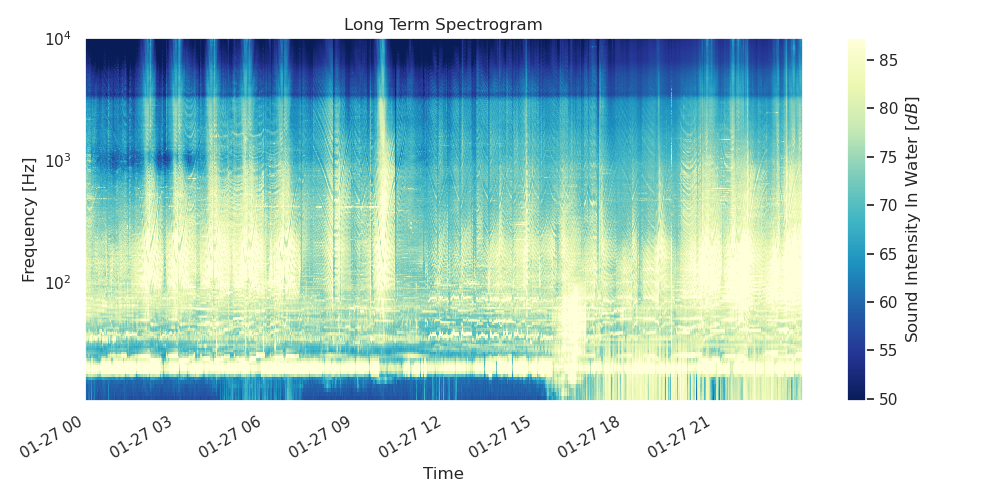

In [11]:
# Select the minimum and the maximum frequency
min_freq = 10
max_freq = 10000

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif"
})
# Plot the LTSA of one day
fig, ax = plt.subplots(figsize=(10, 5))
ds = pypam.utils.select_frequency_range(ds, min_freq=min_freq, max_freq=max_freq, freq_coord='frequency')
pypam.plots.plot_ltsa(ds=ds, data_var='psd', log=True, save_path=None, ax=ax, show=False, freq_coord='frequency',
                      time_coord='time')
plt.show()

In [ ]:
plt.close()

We can also specify the location and then the day/night patter will be shown. But then we need to install the pvblib package

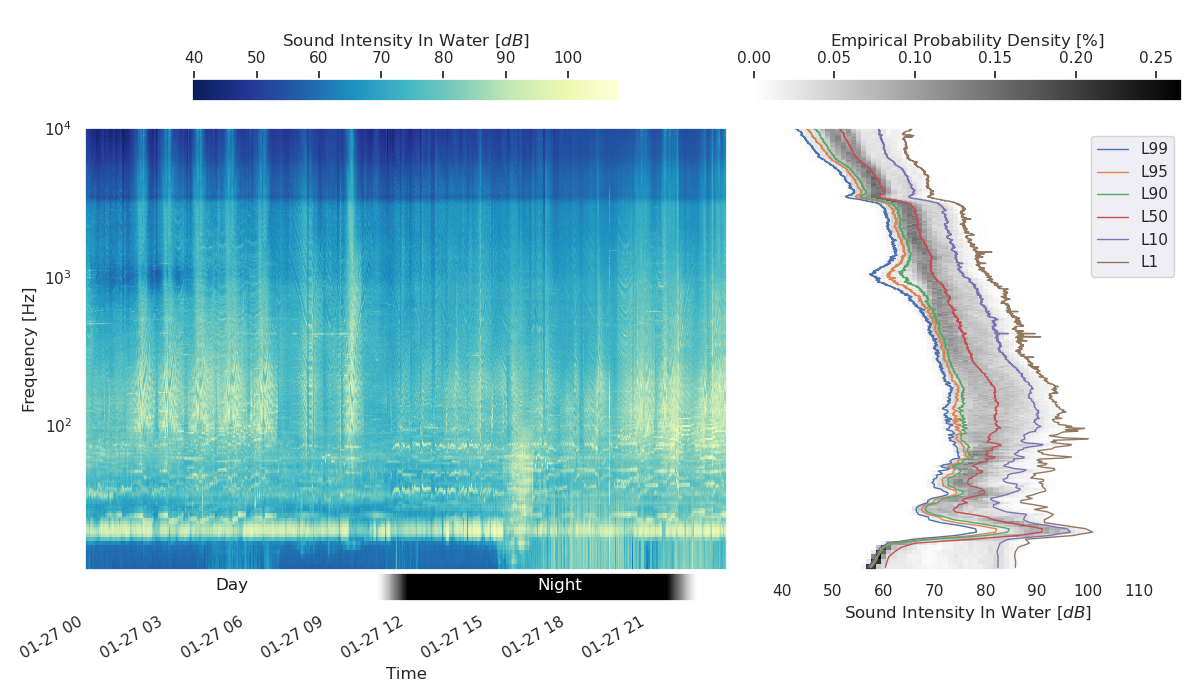

In [12]:
# Lon, Lat
min_psd = 35 # in db
max_psd = 120 # in db
h = 1 # in db
percentiles = [1, 5, 10, 50, 90, 99]
location = [-70.178607, 42.25541] # This is only for SB03, change the values if you change of station to plot
pypam.plots.plot_summary_dataset(ds, percentiles, data_var='psd', time_coord='time', freq_coord='frequency',
                                 min_val=min_psd, max_val=max_psd, show=True, log=True, save_path=None,
                                 location=location)

In [ ]:
plt.close()

## 5. Long-term plotting

We will first select some stations to work on, because plotting all the stations at once would take a lot of space and time. 
We selected SB03 and SB01, but if you prefer other just change the list below

Then we can load all the computed daily millidecade bands in one xarray dataset for each station, and we will save the output as one file (a full year per station!). 
For this we will load the data using  the join_all_ds_output_deployment of pypam, which uses Dask parallel computing for fast access. 

We will load only a part of the data, because the MARS data has spectrum values up to 100 kHz, which is too heavy to process all at once in this machine. 

In [ ]:
RESAMPLE_RESOLUTION = '1H'
# RESAMPLE_RESOLUTION = '1D'
min_freq = 10
max_freq = 10000

In [ ]:
# Only get data from 2021
def load_data_from_station_year(station, year):
    deployment_path = pathlib.Path('./readonly/data/').joinpath(station)
    print('loading station %s...' % station)
    aggregated_ds = pypam.utils.join_all_ds_output_deployment(deployment_path, data_vars=['psd'], datetime_coord='time',
                                                              join_only_if_contains='_%s' % year, load=True,
                                                              parallel=False, freq_band=[min_freq, max_freq],
                                                              freq_coord='frequency',
                                                              drop_variables=['psd_image_colormap',
                                                                              'psd_image',
                                                                              'percentile_image',
                                                                              'percentile_image_colormap'])
    if 'quality_flag' in aggregated_ds.data_vars:
        aggregated_ds = aggregated_ds.where(aggregated_ds.quality_flag == 1, drop=True)
    return aggregated_ds # this assigns an xarray dataset

We can investigate how 1-year dataset looks

In [ ]:
stations_to_load = ['SB03', 'MARS'] # Make a list of 2 stations to compare
ds_collection = {}
for station in stations_to_load:
    ds_collection[station] = load_data_from_station_year(station, 2021)

### Plot the HMB as yearly long-term spectrograms

For memory reasons, plotting 1-minute resolution spectrograms for a full year is not possible. Therefore, we need to downsample the data (by taking the median, because values are in db). We can downsample it to hours or days.
Be patient, resampling a full year can take a little while...

In [ ]:
station_to_plot = 'SB03' # By changing these value all the plots below will be for the selected stations

In [ ]:
# Need to resample first, otherwise it does not plot!
ds_resampled = ds_collection[station_to_plot].resample(time=RESAMPLE_RESOLUTION).median()

In [ ]:
ds_resampled

Again for the plot we need to select the frequency range we want to plot

In [ ]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif"
})
fig, ax = plt.subplots(figsize=(10, 5))
pypam.plots.plot_ltsa(ds=ds_resampled, data_var='psd', log=True, ax=ax, show=False, freq_coord='frequency',
                      time_coord='time')
ax.set_title(station_to_plot)
plt.show()

In [ ]:
plt.close()

### Plot the SPD

In [ ]:
# First, convert the HMB output to SPD like we did for the small wav files examples
percentiles = [1, 10, 50, 90, 99]
min_psd = 35 # in db
max_psd = 120 # in db
h = 1 # in db
ds_spd = pypam.utils.compute_spd(ds_resampled, data_var='psd', percentiles=percentiles, min_val=min_psd, 
                                 max_val=max_psd, h=h)

In [ ]:
# Plot the obtained output
fig, ax = plt.subplots(figsize=(10,5))
pypam.plots.plot_spd(spd=ds_spd, log=True, save_path=None, ax=ax, show=False)
plt.show()

In [ ]:
plt.close()

### Plot a summary

In [ ]:
# If we're not interested in the location
pypam.plots.plot_summary_dataset(ds_resampled, percentiles, data_var='psd', time_coord='time', freq_coord='frequency',
                                 min_val=min_psd, max_val=max_psd, show=True, log=True, save_path=None,
                                 location=None)

In [ ]:
plt.close()

## 6. Whale presence indices

Indices are the ratio of mean power spectral density (PSD) within the frequency band of peak call energy to mean PSD at background frequencies.
These peak and background frequencies will be illustrated in the summary plot and call index calculations below

In [ ]:
# Define the frequencies that are used to compute call indices
bluepeak = np.array([42, 43])
finpeak = np.array([20, 21])
bluebackground = np.array([37, 50])
finbackground = np.array([12, 34])

We can plot a LTSA with a line showing these values, but we will resample it first to daily spectra to get daily indices. 
Be patient, resampling a full year can take a little while...

In [ ]:
whale_station1 = 'SB03' # Choose the station you want to plot
daily_resampled1 = ds_collection[whale_station1].resample(time='1D').median()  # Resample to daily spectra

In [ ]:
whale_station2 = 'MARS' # Choose the second station you want to plot
daily_resampled2 = ds_collection[whale_station2].resample(time='1D').median()  # Resample to daily spectra

In [ ]:
# Then, plot the LTSA
fig, ax = plt.subplots(figsize=(10, 5))
pypam.plots.plot_ltsa(ds=daily_resampled1, data_var='psd', log=True, ax=ax, show=False, freq_coord='frequency',
                      time_coord='time')
ax.axhline(np.mean(bluepeak),color='black',linestyle='--',linewidth=0.5)
ax.axhline(np.mean(finpeak),color='black',linestyle='--',linewidth=0.5)
ax.set_title('SB03')
plt.show()

In [ ]:
plt.close()

In [ ]:
def compute_whale_index(peak, background, daily_ds):
    pk = daily_ds.sel(frequency=peak).psd.mean(dim='frequency')
    bg = daily_ds.sel(frequency=background).psd.mean(dim='frequency')
    CI = pk / bg
    return CI

In [ ]:
# Compute the whale indices
finCI1 = compute_whale_index(finpeak, finbackground, daily_resampled1)
blueCI1 = compute_whale_index(bluepeak, bluebackground, daily_resampled1)
finCI2 = compute_whale_index(finpeak, finbackground, daily_resampled2)
blueCI2 = compute_whale_index(bluepeak, bluebackground, daily_resampled2)

In [ ]:
# Plot the whale indices
fig, ax = plt.subplots(2, 1, figsize=(10,6), sharex=True, sharey=True)
ax[0].plot(daily_resampled1.time.values, blueCI1, '.', label='blue whale')
ax[0].plot(daily_resampled1.time.values, finCI1, 'o', markerfacecolor='none', label='fin whale')
ax[0].axhline(1, color='black', linestyle='--', linewidth=0.5)
ax[0].set_facecolor('white')
ax[0].set_title(whale_station1)

ax[1].plot(daily_resampled2.time.values, blueCI2, '.', label='blue whale')
ax[1].plot(daily_resampled2.time.values, finCI2, 'o', markerfacecolor='none', label='fin whale')
ax[1].axhline(1, color='black', linestyle='--', linewidth=0.5)
ax[1].set_facecolor('white')
ax[1].set_title(whale_station2)

plt.suptitle('Daily whale call index')
plt.ylabel('Call index')
plt.legend()
plt.show()

In [ ]:
plt.close()

## 7. Daily patterns

We can plot the hourly data we have obtained for the entire year to see if there are any daily patterns which repeat

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ds_freq = pypam.utils.freq_band_aggregation(ds_resampled, data_var='psd', aggregation_freq_band=[10, 20])
pypam.plots.plot_daily_patterns_from_ds(ds=ds_freq, data_var='psd', show=True, datetime_coord='time', ax=ax)

In [ ]:
plt.close()

## 8. Compare data between stations

We can compare the spectrums of two locations, by visualizing the median and the [10, 90] percentile spectrum of each location.

In [ ]:
# Spectral Density comparison
ds_collection_resampled = {'SB03': ds_collection['SB03'].resample(time='1H').median(),
                           'MARS': ds_collection['MARS'].resample(time='1H').median()}

In [ ]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif"
})
fig, ax = plt.subplots(figsize=(10, 5))
ax = pypam.plots.plot_multiple_spectrum_median(ds_collection_resampled, 'psd', percentiles='default', 
                                               frequency_coord='frequency',
                                               log=True, save_path=None, 
                                               ax=ax, show=True, time_coord='time')

In [ ]:
plt.close()

### Aggregations and boxplots

We can now plot the evolution of all the stations by calling the bin aggregation function. It will compute the median of all the values included in the frequency band specified.
Then it will aggregate all the values of the dataset in time to match the specified time frequency. 
PyPAM has a function to plot the evolution of one or multiple stations. 

In [ ]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif"
})
aggregation_time = 'M'  # H, D, W, or M (hour, day, week or month)
aggregation_freq_band = [10, 200]
mode = 'violin'  # It can be boxplot, violin or quantiles
fig, ax = plt.subplots(figsize=(10, 6))
ax = pypam.plots.plot_multiple_aggregation_evolution(ds_dict=ds_collection,
                                                     data_var='psd',
                                                     mode=mode,
                                                     show=True,
                                                     datetime_coord='time',
                                                     aggregation_time=aggregation_time,
                                                     freq_coord='frequency',
                                                     aggregation_freq_band=aggregation_freq_band,
                                                     ax=ax,
                                                     alpha=0.5)
ax.set_title('Median sound intensity in water from frequency band %s to %s Hz' %
             (aggregation_freq_band[0], aggregation_freq_band[1]))
plt.tight_layout()

In [ ]:
plt.close()

## 9. Conversions: from HMB to decidecade bands

We will work only with one day of data, just to show it (it will be faster!)

In [ ]:
ds = xr.open_dataset('./readonly/data/MARS/MARS_20210316.nc')

# Convert back to upa for the sum operations
ds['psd'] = np.power(10, ds['psd'] / 10.0 - np.log10(1))

In [ ]:
# We have to know the sampling frequency, and nfft will be the same value
fs = 256000
nfft = fs
fft_bin_width = fs / nfft

In [ ]:
changing_frequency = 435
bands_limits, bands_c = pypam.utils.get_decidecade_limits(band=[changing_frequency + 1, 256000/2], nfft=nfft, fs=fs)
bands_limits_low, bands_c_low = pypam.utils.get_decidecade_limits(band=[10, changing_frequency], nfft=nfft, fs=fs)

In [ ]:
# We need to split the dataset in two, the part which is below the changing frequency and the part which is above
low_psd = ds['psd'].where(ds.frequency <= changing_frequency, drop=True)
low_decidecade = pypam.utils.spectra_ds_to_bands(low_psd, bands_limits_low, bands_c_low, fft_bin_width, db=False)

In [ ]:
high_psd = ds['psd'].where(ds.frequency > changing_frequency, drop=True)
high_decidecade = high_psd.groupby_bins('frequency', bins=bands_limits, labels=bands_c, right=True).sum()
bandwidths = np.diff(bands_limits)
high_decidecade = high_decidecade / bandwidths

In [ ]:
decidecade_psd = xr.merge([{'psd': low_decidecade}, {'psd': high_decidecade}])
decidecade_psd = 10 * np.log10(decidecade_psd)